In [370]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns
#pd.set_option('display.max_rows', None) # display all columns

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [442]:
data = pd.read_csv('data/Kobe.csv')

In [443]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [444]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [445]:
#Почти для 5000 наблюдений нет информации о классе, избавимся от них:
data=data[data.shot_made_flag.notnull()]

data.shape


(25697, 25)

In [446]:
data.team_name.unique()

array(['Los Angeles Lakers'], dtype=object)

In [447]:
data.team_id.unique()

array([1610612747], dtype=int64)

In [448]:
#Удалим team_name и team_id  т.к там одно значение, классфикации оно не поможет
data.drop(['team_name', 'team_id'], axis=1, inplace=True)

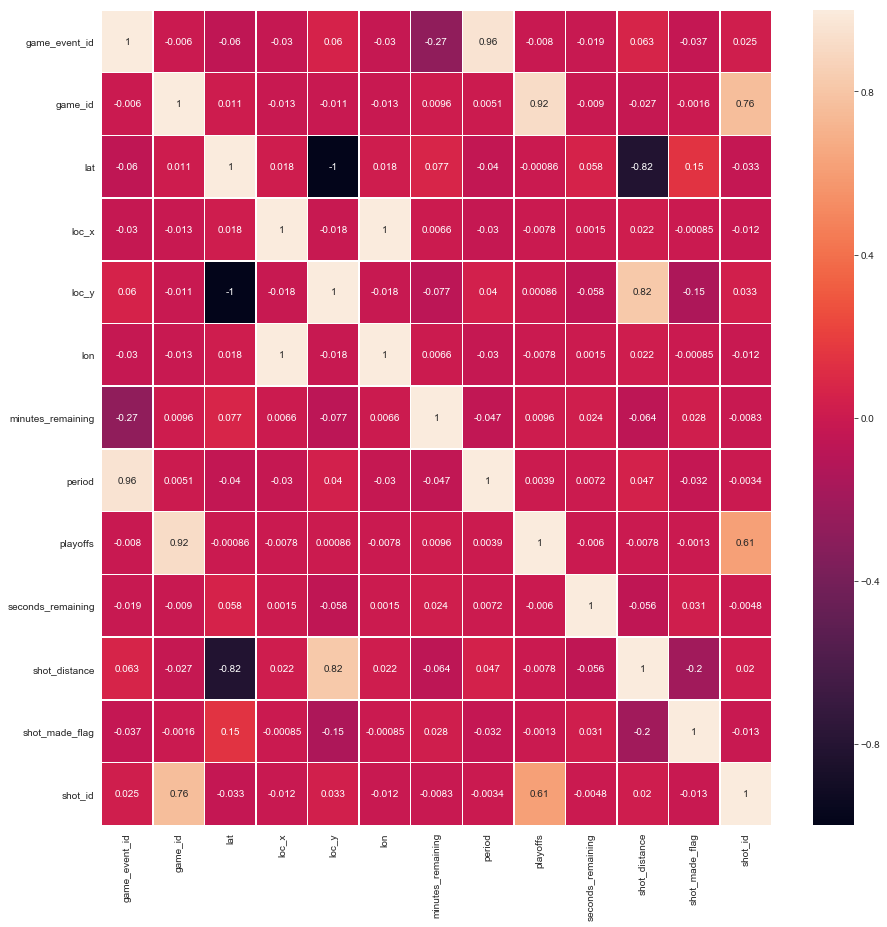

In [449]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data.corr(), linewidths=.5, annot=True,)

In [450]:
#lat коррелирует с loc_x, lon c loc_y. Удалим кого-то из этих пар
data.drop(['lat', 'lon'], axis=1, inplace=True)

In [451]:
#так же врядли на какую-то информацию несут game_id	 и  game_event_id
data.drop(['game_id', 'game_event_id'], axis=1, inplace=True)

In [452]:
data.columns

Index(['action_type', 'combined_shot_type', 'loc_x', 'loc_y',
       'minutes_remaining', 'period', 'playoffs', 'season',
       'seconds_remaining', 'shot_distance', 'shot_made_flag', 'shot_type',
       'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_date',
       'matchup', 'opponent', 'shot_id'],
      dtype='object')

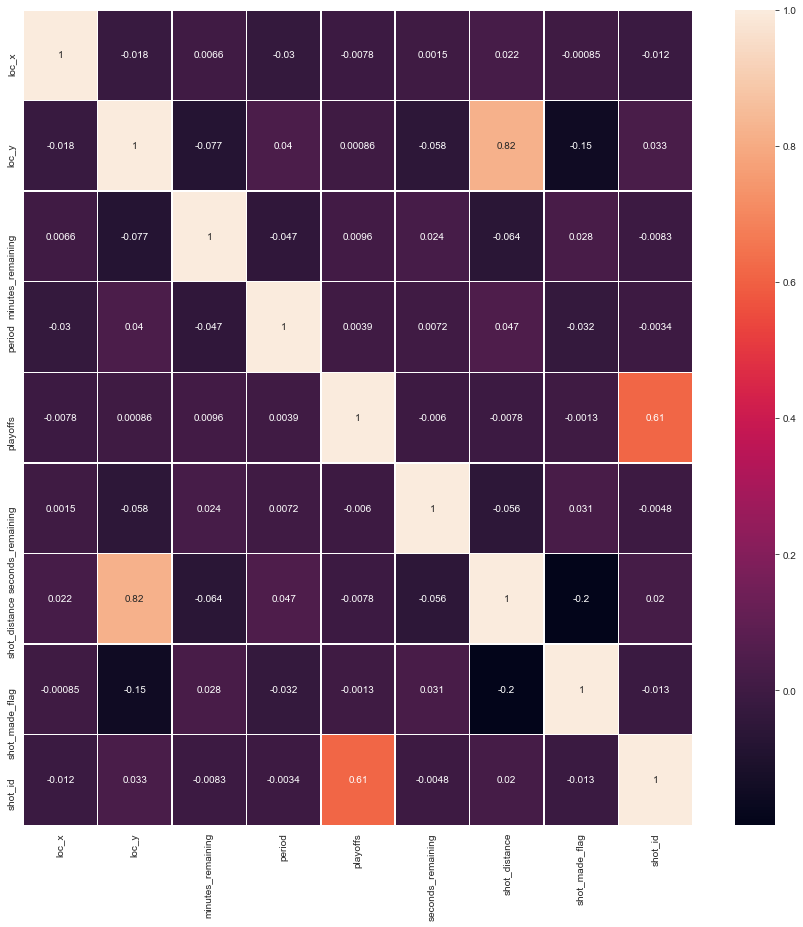

In [453]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data.corr(), linewidths=.5, annot=True,)

In [454]:
data.describe()

,loc_x,loc_y,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,shot_id
count,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000
mean,7.148422,91.257345,4.886796,2.520800,0.146243,28.311554,13.457096,0.446161,15328.166946
std,110.073147,88.152106,3.452475,1.151626,0.353356,17.523392,9.388725,0.497103,8860.462397
min,-250.000000,-44.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,-67.000000,4.000000,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,7646.000000
50%,0.000000,74.000000,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,15336.000000
75%,94.000000,160.000000,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,22976.000000
max,248.000000,791.000000,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,30697.000000


In [455]:
#красивую визуализацию нашел на кегле

In [456]:
data[data.shot_made_flag.notnull()]

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent,shot_id
1,Jump Shot,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,138,175,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,0,0,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,-145,-11,9,3,0,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,LAL @ POR,POR,6
6,Layup Shot,Layup,0,0,8,3,0,2000-01,52,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-10-31,LAL @ POR,POR,7
8,Jump Shot,Jump Shot,-65,108,6,3,0,2000-01,12,12,1.0,2PT Field Goal,Left Side(L),In The Paint (Non-RA),8-16 ft.,2000-10-31,LAL @ POR,POR,9
9,Running Jump Shot,Jump Shot,-33,125,3,3,0,2000-01,36,12,0.0,2PT Field Goal,Center(C),In The Paint (Non-RA),8-16 ft.,2000-10-31,LAL @ POR,POR,10
10,Jump Shot,Jump Shot,-94,238,1,3,0,2000-01,56,25,0.0,3PT Field Goal,Left Side Center(LC),Above the Break 3,24+ ft.,2000-10-31,LAL @ POR,POR,11
11,Jump Shot,Jump Shot,121,127,11,1,0,2000-01,0,17,1.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,2000-11-01,LAL vs. UTA,UTA,12


Text(0.5, 1.0, 'Коби промазал')

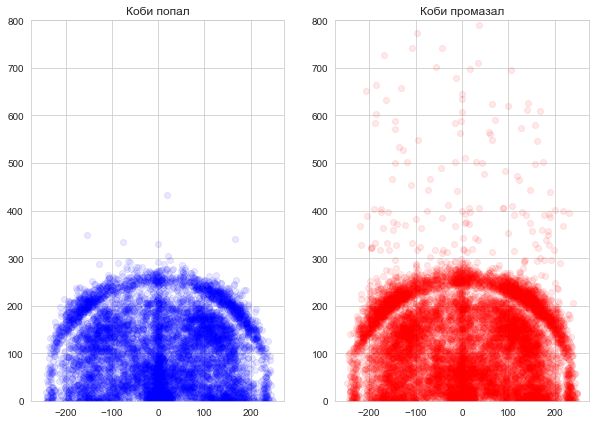

In [457]:
#Логично с  дальних он попадает реже
alpha = 0.09
plt.figure(figsize=(10,7))

# loc_x and loc_y
plt.subplot(121)
plt.scatter(data.loc_x[data.shot_made_flag==1], data.loc_y[data.shot_made_flag==1], color='blue', alpha=alpha)
#plt.scatter(data.loc_x[data.shot_made_flag==0], data.loc_y[data.shot_made_flag==0], color='red', alpha=alpha)
plt.ylim(0,800)
plt.title('Коби попал')

# loc_x and loc_y
plt.subplot(122)
plt.ylim(0,800)
plt.scatter(data.loc_x[data.shot_made_flag==0], data.loc_y[data.shot_made_flag==0], color='red', alpha=alpha)
plt.title('Коби промазал')

In [458]:
data.head()

,action_type,combined_shot_type,loc_x,loc_y,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,game_date,matchup,opponent,shot_id
1,Jump Shot,Jump Shot,-157,0,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,-101,135,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,138,175,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,0,0,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,-145,-11,9,3,0,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,2000-10-31,LAL @ POR,POR,6


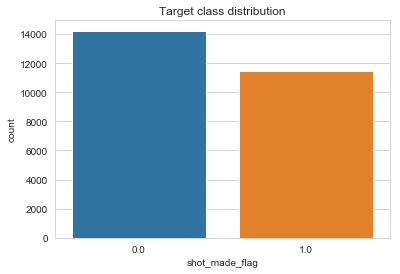

In [459]:
#Посмотрим на распредление целевой переменной-ну относительно сбалансирвоаны

import seaborn as sns
ax = plt.axes()
sns.countplot(x='shot_made_flag', data=data, ax=ax);
ax.set_title('Target class distribution')
plt.show()

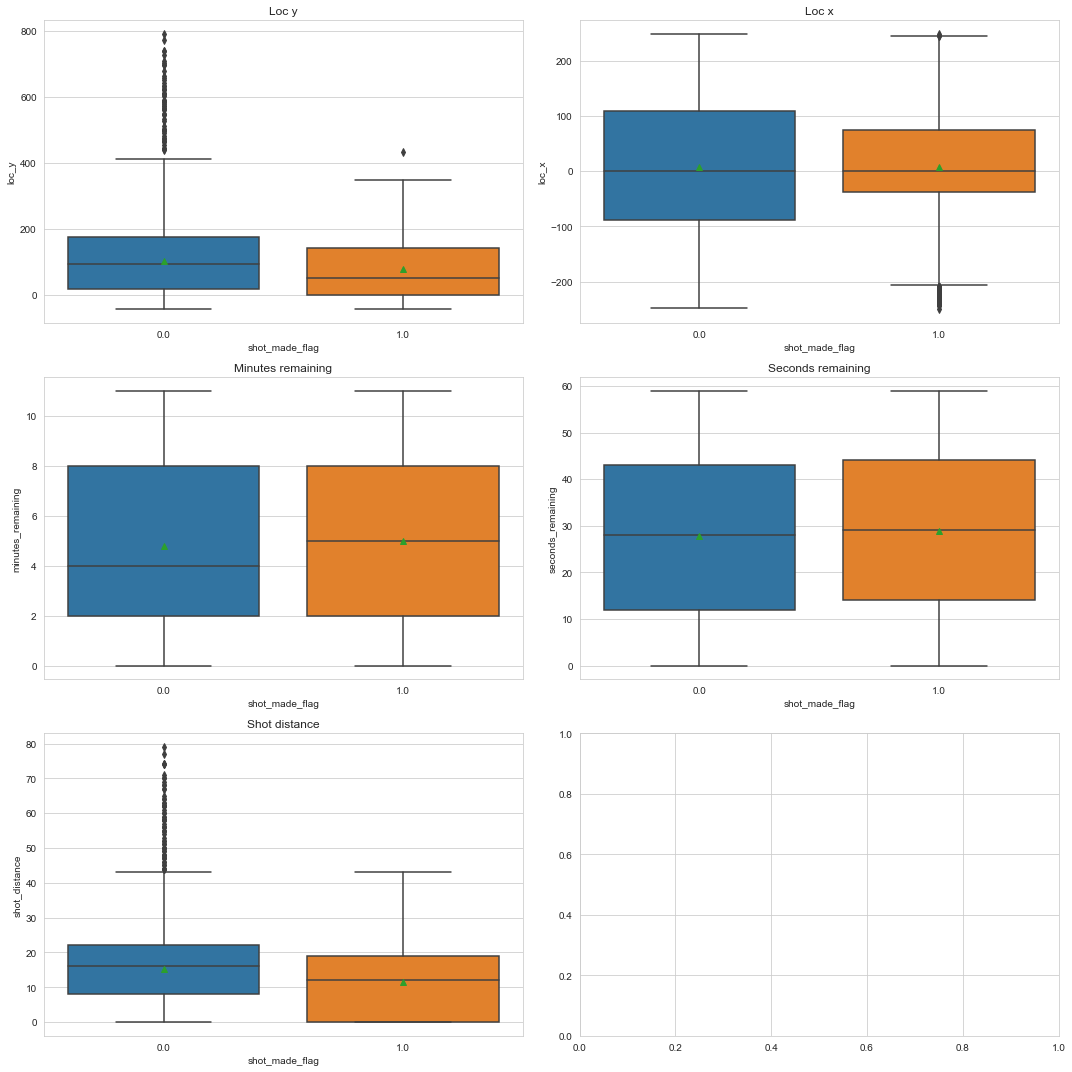

In [460]:
f, axarr = plt.subplots(3, 2, figsize=(15, 15))


sns.boxplot(y='loc_y', x='shot_made_flag', data=data, showmeans=True, ax=axarr[0, 0])
sns.boxplot(y='loc_x', x='shot_made_flag', data=data, showmeans=True, ax=axarr[0, 1])
sns.boxplot(y='minutes_remaining', x='shot_made_flag', showmeans=True, data=data, ax=axarr[1, 0])
sns.boxplot(y='seconds_remaining', x='shot_made_flag', showmeans=True, data=data, ax=axarr[1, 1])
sns.boxplot(y='shot_distance', x='shot_made_flag', data=data, showmeans=True, ax=axarr[2, 0])


axarr[0, 0].set_title('Loc y')
axarr[0, 1].set_title('Loc x')
axarr[1, 0].set_title('Minutes remaining')
axarr[1, 1].set_title('Seconds remaining')
axarr[2, 0].set_title('Shot distance')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Combined shot type')

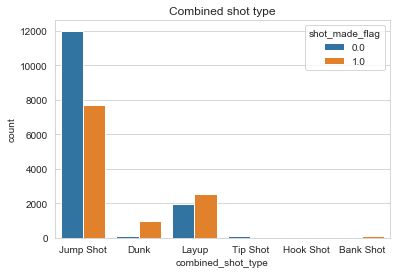

In [461]:
# c jump shot Kobe часто нарпимер промахивался
sns.countplot(x="combined_shot_type", hue="shot_made_flag", data=data).set_title('Combined shot type')


Text(0.5, 1.0, 'action_type')

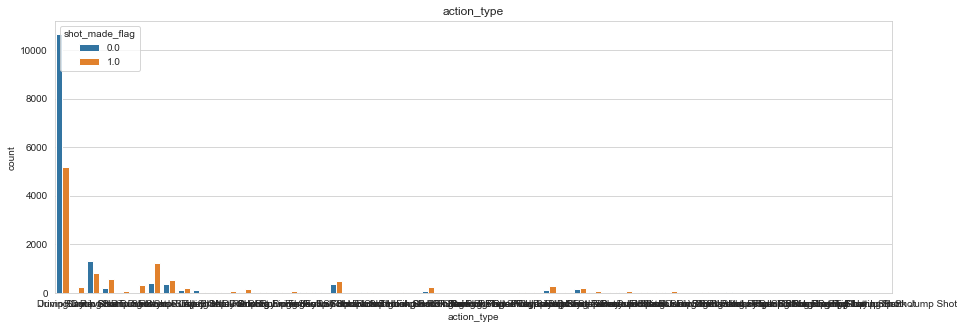

In [462]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="action_type", hue="shot_made_flag", data=data).set_title('action_type')

In [463]:
len(data.action_type.unique())

55

In [464]:
rare_action_types = data['action_type'].value_counts().sort_values().index.values[:16]


In [465]:
len(rare_action_types)

16

In [466]:
data.loc[data['action_type'].isin(rare_action_types), 'action_type'] = 'Other'

In [467]:
len(data.action_type.unique())

40

In [468]:
data.action_type.unique()

array(['Jump Shot', 'Driving Dunk Shot', 'Layup Shot',
       'Running Jump Shot', 'Reverse Dunk Shot', 'Slam Dunk Shot',
       'Driving Layup Shot', 'Turnaround Jump Shot', 'Reverse Layup Shot',
       'Tip Shot', 'Running Hook Shot', 'Alley Oop Dunk Shot',
       'Dunk Shot', 'Alley Oop Layup shot', 'Running Dunk Shot',
       'Driving Finger Roll Shot', 'Running Layup Shot',
       'Finger Roll Shot', 'Fadeaway Jump Shot', 'Follow Up Dunk Shot',
       'Hook Shot', 'Other', 'Jump Hook Shot', 'Jump Bank Shot',
       'Driving Hook Shot', 'Driving Finger Roll Layup Shot',
       'Fadeaway Bank shot', 'Pullup Jump shot', 'Finger Roll Layup Shot',
       'Turnaround Fadeaway shot', 'Driving Reverse Layup Shot',
       'Driving Slam Dunk Shot', 'Step Back Jump shot',
       'Turnaround Bank shot', 'Reverse Slam Dunk Shot',
       'Floating Jump shot', 'Running Bank shot', 'Driving Jump shot',
       'Putback Layup Shot', 'Pullup Bank shot'], dtype=object)

Text(0.5, 1.0, 'action_type')

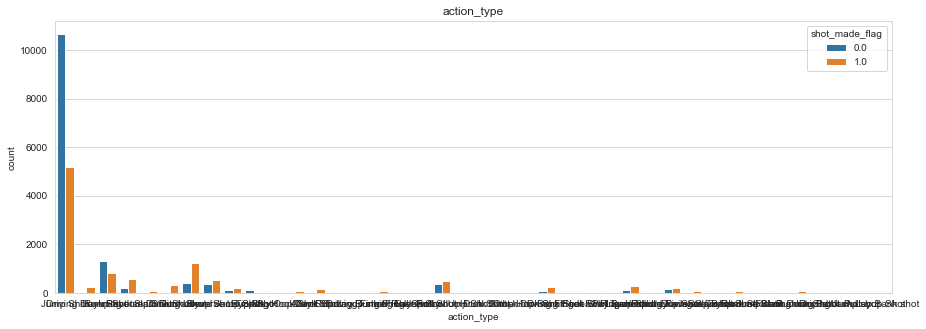

In [469]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="action_type", hue="shot_made_flag", data=data).set_title('action_type')

Text(0.5, 1.0, 'Season')

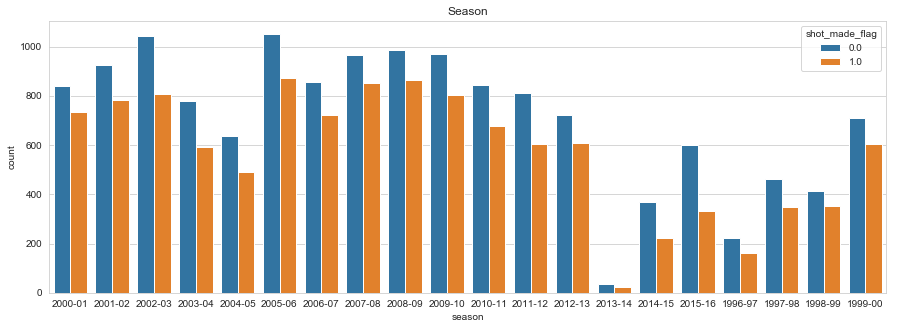

In [470]:
# по сезонам сложно что-то скзать на первый взгляд
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="season", hue="shot_made_flag", data=data).set_title('Season')


Text(0.5, 1.0, 'Period')

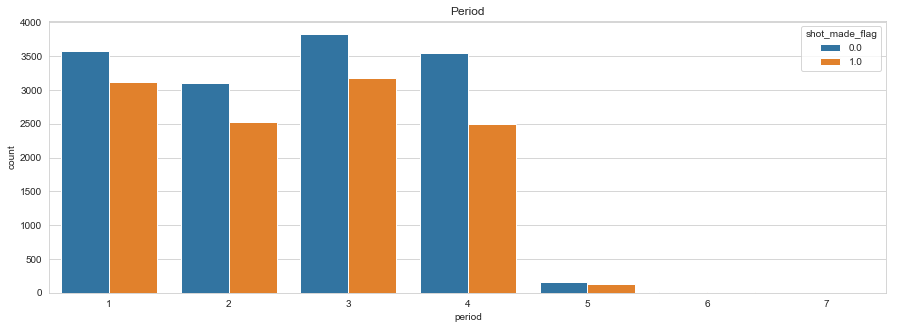

In [471]:
#есть ощущуение что в 4 периодеб например, он мажет чаще
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="period", hue="shot_made_flag", data=data).set_title('Period')


Text(0.5, 1.0, 'Playoffs')

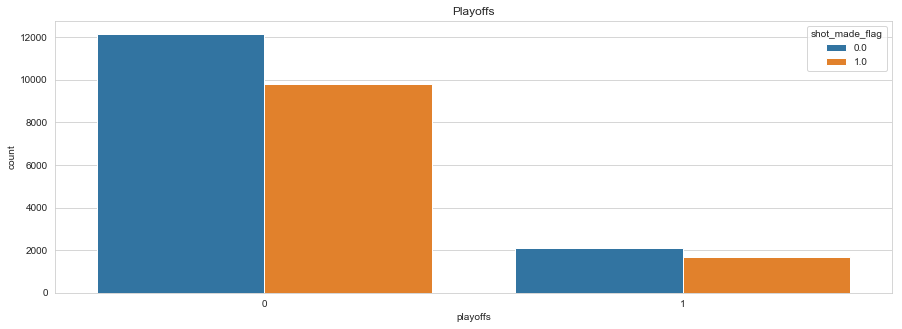

In [472]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="playoffs", hue="shot_made_flag", data=data).set_title('Playoffs')


Text(0.5, 1.0, 'Shot Type')

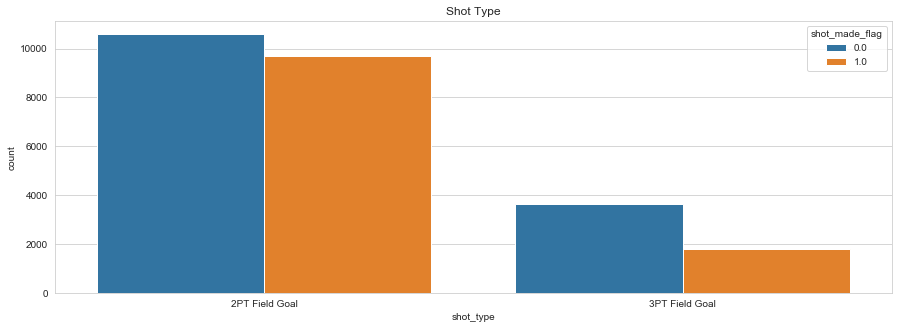

In [473]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="shot_type", hue="shot_made_flag", data=data).set_title('Shot Type')


Text(0.5, 1.0, 'Shot Zone Area')

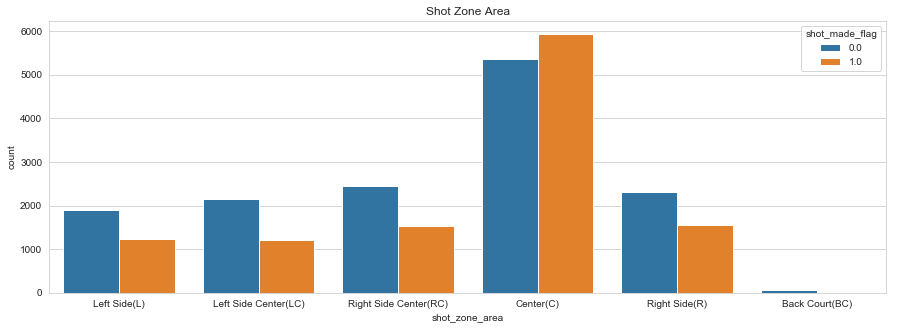

In [474]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="shot_zone_area", hue="shot_made_flag", data=data).set_title('Shot Zone Area')


Text(0.5, 1.0, 'Shot Zone Basic')

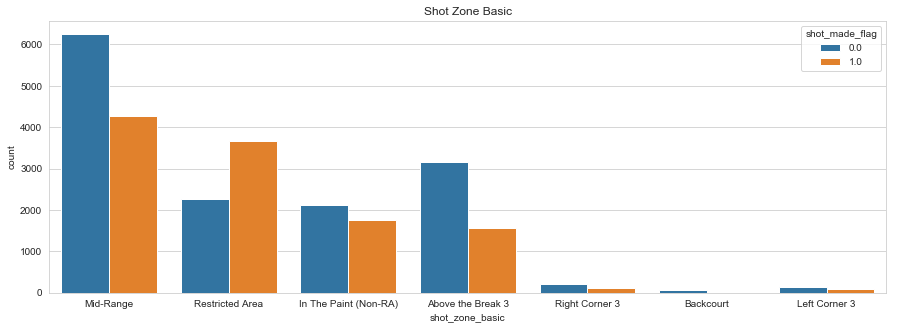

In [475]:
# по зоне должно не плохо делаиться

fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="shot_zone_basic", hue="shot_made_flag", data=data).set_title('Shot Zone Basic')


Text(0.5, 1.0, 'Shot Zone Range')

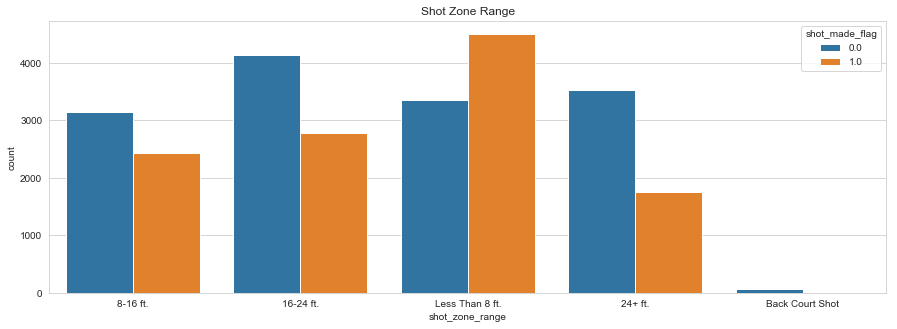

In [476]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="shot_zone_range", hue="shot_made_flag", data=data).set_title('Shot Zone Range')


### 2) Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.

In [477]:
# Переведем минуты в секунды
data['seconds_from_period_end'] = 60 * data['minutes_remaining'] + data['seconds_remaining']


In [478]:
data.drop(['minutes_remaining', 'seconds_remaining'], axis=1, inplace=True)

In [479]:
# еще была идея что в конце периода часто наудачу броски идут неподготовленные
data['last_5_sec_in_period'] = data['seconds_from_period_end'] < 5

Text(0.5, 1.0, 'Shot Zone Area')

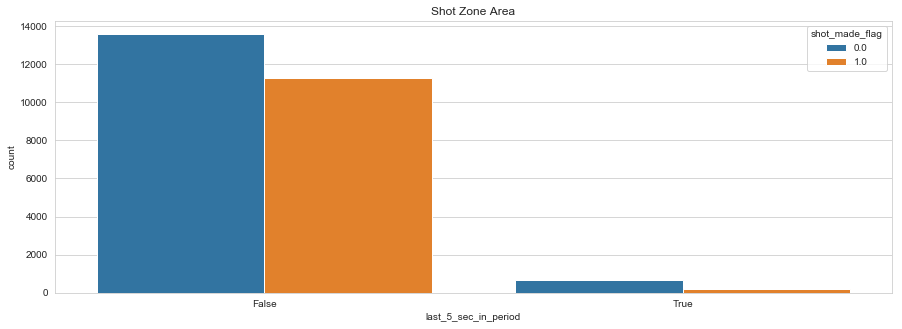

In [480]:
#как будто так и есть
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="last_5_sec_in_period", hue="shot_made_flag", data=data).set_title('Shot Zone Area')


In [481]:
#Вытащим признак игры дома-в гостях
data['home_play'] = data['matchup'].str.contains('vs').astype('int')
data.drop('matchup', axis=1, inplace=True)

Text(0.5, 1.0, 'Shot Zone Area')

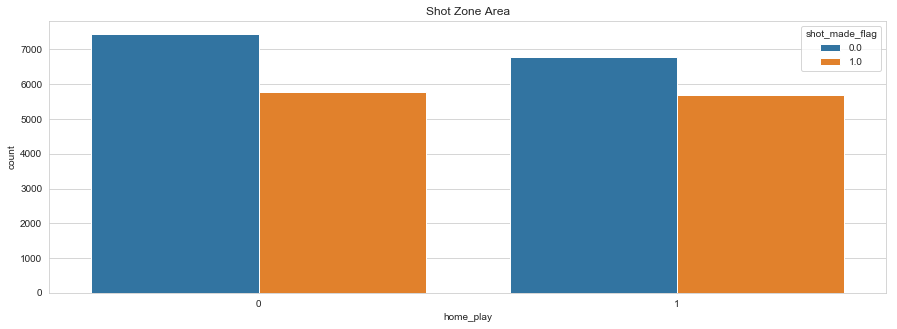

In [482]:
# Дома как будто бы чаще Коби пападает
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(x="home_play", hue="shot_made_flag", data=data).set_title('Shot Zone Area')

In [483]:
#вытащи врпменыне атрибуты
data['game_date'] = pd.to_datetime(data['game_date'])
data['game_year'] = data['game_date'].dt.year
data['game_month'] = data['game_date'].dt.month
data['game_week'] = data['game_date'].dt.week
data['game_day'] = data['game_date'].dt.day
data.drop('game_date', axis=1, inplace=True)

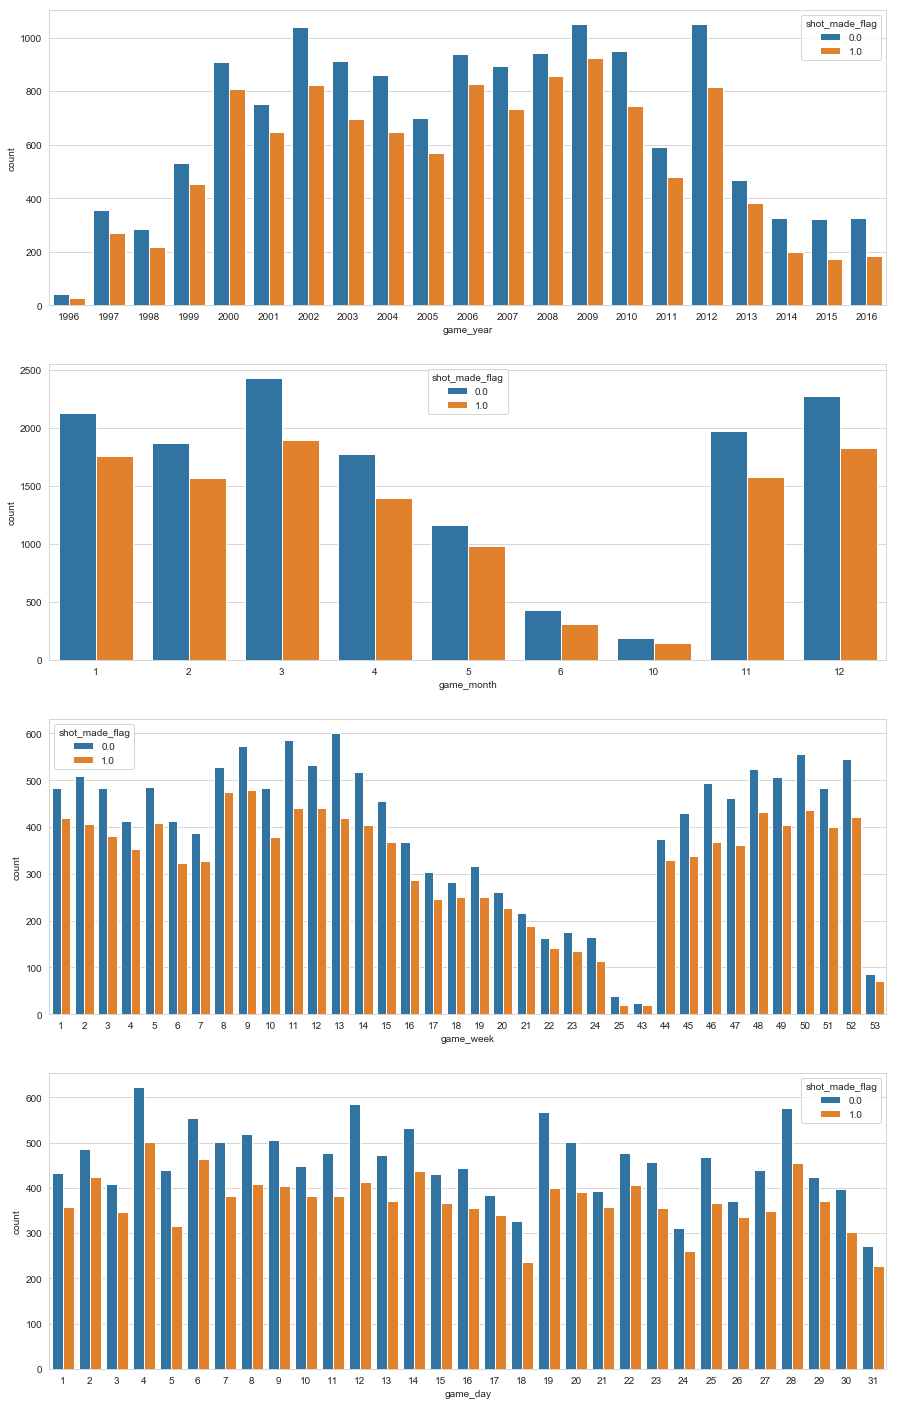

In [484]:
# кажется , в конце карьеры прохов стало больше
f, axarr = plt.subplots(4, figsize=(15, 25))

sns.countplot(x="game_year", hue="shot_made_flag", data=data, ax=axarr[0])
sns.countplot(x="game_month", hue="shot_made_flag", data=data, ax=axarr[1])
sns.countplot(x="game_week", hue="shot_made_flag", data=data, ax=axarr[2])
sns.countplot(x="game_day", hue="shot_made_flag", data=data, ax=axarr[3])

#axarr[0].set_title('game_year')
#axarr[1].set_title('game_month')
#axarr[2].set_title('game_week')
#axarr[3].set_title('game_day')

In [485]:
data.head()

,action_type,combined_shot_type,loc_x,loc_y,period,playoffs,season,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,opponent,shot_id,seconds_from_period_end,last_5_sec_in_period,home_play,game_year,game_month,game_week,game_day
1,Jump Shot,Jump Shot,-157,0,1,0,2000-01,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,2,622,False,0,2000,10,44,31
2,Jump Shot,Jump Shot,-101,135,1,0,2000-01,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,POR,3,465,False,0,2000,10,44,31
3,Jump Shot,Jump Shot,138,175,1,0,2000-01,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,POR,4,412,False,0,2000,10,44,31
4,Driving Dunk Shot,Dunk,0,0,2,0,2000-01,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,POR,5,379,False,0,2000,10,44,31
5,Jump Shot,Jump Shot,-145,-11,3,0,2000-01,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,POR,6,572,False,0,2000,10,44,31


In [486]:
data[['season','game_year']].corr()

,game_year
game_year,1.0


In [487]:
# game_year зря сделали-выкнем
data.drop('season', axis=1, inplace=True)

In [488]:
 #  Переведем  Loc_x, and loc_y в  интервал
data['loc_x'] = pd.cut(data['loc_x'], 25)
data['loc_y'] = pd.cut(data['loc_y'], 25)

In [490]:
#Encode categorical variable
categorial_cols = [
    'action_type', 'combined_shot_type', 'period', 'shot_type',
    'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'game_year',
    'game_month', 'opponent', 'loc_x', 'loc_y']

for cc in categorial_cols:
    dummies = pd.get_dummies(data[cc])
    dummies = dummies.add_prefix("{}#".format(cc))
    data.drop(cc, axis=1, inplace=True)
    data = data.join(dummies)

In [491]:
data.head()

,playoffs,shot_distance,shot_made_flag,shot_id,seconds_from_period_end,last_5_sec_in_period,home_play,game_week,game_day,action_type#Alley Oop Dunk Shot,action_type#Alley Oop Layup shot,action_type#Driving Dunk Shot,action_type#Driving Finger Roll Layup Shot,action_type#Driving Finger Roll Shot,action_type#Driving Hook Shot,action_type#Driving Jump shot,action_type#Driving Layup Shot,action_type#Driving Reverse Layup Shot,action_type#Driving Slam Dunk Shot,action_type#Dunk Shot,action_type#Fadeaway Bank shot,action_type#Fadeaway Jump Shot,action_type#Finger Roll Layup Shot,action_type#Finger Roll Shot,action_type#Floating Jump shot,action_type#Follow Up Dunk Shot,action_type#Hook Shot,action_type#Jump Bank Shot,action_type#Jump Hook Shot,action_type#Jump Shot,action_type#Layup Shot,action_type#Other,action_type#Pullup Bank shot,action_type#Pullup Jump shot,action_type#Putback Layup Shot,action_type#Reverse Dunk Shot,action_type#Reverse Layup Shot,action_type#Reverse Slam Dunk Shot,action_type#Running Bank shot,action_type#Running Dunk Shot,action_type#Running Hook Shot,action_type#Running Jump Shot,action_type#Running Layup Shot,action_type#Slam Dunk Shot,action_type#Step Back Jump shot,action_type#Tip Shot,action_type#Turnaround Bank shot,action_type#Turnaround Fadeaway shot,action_type#Turnaround Jump Shot,combined_shot_type#Bank Shot,combined_shot_type#Dunk,combined_shot_type#Hook Shot,combined_shot_type#Jump Shot,combined_shot_type#Layup,combined_shot_type#Tip Shot,period#1,period#2,period#3,period#4,period#5,period#6,period#7,shot_type#2PT Field Goal,shot_type#3PT Field Goal,shot_zone_area#Back Court(BC),shot_zone_area#Center(C),shot_zone_area#Left Side Center(LC),shot_zone_area#Left Side(L),shot_zone_area#Right Side Center(RC),shot_zone_area#Right Side(R),shot_zone_basic#Above the Break 3,shot_zone_basic#Backcourt,shot_zone_basic#In The Paint (Non-RA),shot_zone_basic#Left Corner 3,shot_zone_basic#Mid-Range,shot_zone_basic#Restricted Area,shot_zone_basic#Right Corner 3,shot_zone_range#16-24 ft.,shot_zone_range#24+ ft.,shot_zone_range#8-16 ft.,shot_zone_range#Back Court Shot,shot_zone_range#Less Than 8 ft.,game_year#1996,game_year#1997,game_year#1998,game_year#1999,game_year#2000,game_year#2001,game_year#2002,game_year#2003,game_year#2004,game_year#2005,game_year#2006,game_year#2007,game_year#2008,game_year#2009,game_year#2010,game_year#2011,game_year#2012,game_year#2013,game_year#2014,game_year#2015,game_year#2016,game_month#1,game_month#2,game_month#3,game_month#4,game_month#5,game_month#6,game_month#10,game_month#11,game_month#12,opponent#ATL,opponent#BKN,opponent#BOS,opponent#CHA,opponent#CHI,opponent#CLE,opponent#DAL,opponent#DEN,opponent#DET,opponent#GSW,opponent#HOU,opponent#IND,opponent#LAC,opponent#MEM,opponent#MIA,opponent#MIL,opponent#MIN,opponent#NJN,opponent#NOH,opponent#NOP,opponent#NYK,opponent#OKC,opponent#ORL,opponent#PHI,opponent#PHX,opponent#POR,opponent#SAC,opponent#SAS,opponent#SEA,opponent#TOR,opponent#UTA,opponent#VAN,opponent#WAS,"loc_x#(-250.498, -230.08]","loc_x#(-230.08, -210.16]","loc_x#(-210.16, -190.24]","loc_x#(-190.24, -170.32]","loc_x#(-170.32, -150.4]","loc_x#(-150.4, -130.48]","loc_x#(-130.48, -110.56]","loc_x#(-110.56, -90.64]","loc_x#(-90.64, -70.72]","loc_x#(-70.72, -50.8]","loc_x#(-50.8, -30.88]","loc_x#(-30.88, -10.96]","loc_x#(-10.96, 8.96]","loc_x#(8.96, 28.88]","loc_x#(28.88, 48.8]","loc_x#(48.8, 68.72]","loc_x#(68.72, 88.64]","loc_x#(88.64, 108.56]","loc_x#(108.56, 128.48]","loc_x#(128.48, 148.4]","loc_x#(148.4, 168.32]","loc_x#(168.32, 188.24]","loc_x#(188.24, 208.16]","loc_x#(208.16, 228.08]","loc_x#(228.08, 248.0]","loc_y#(-44.835, -10.6]","loc_y#(-10.6, 22.8]","loc_y#(22.8, 56.2]","loc_y#(56.2, 89.6]","loc_y#(89.6, 123.0]","loc_y#(123.0, 156.4]","loc_y#(156.4, 189.8]","loc_y#(189.8, 223.2]","loc_y#(223.2, 256.6]","loc_y#(256.6, 290.0]","loc_y#(290.0, 323.4]","loc_y#(323.4, 356.8]","loc_y#(356.8, 390.2]","loc_y#(390.2, 423.6]","loc_y#(423.6, 457.0]","loc_y#(457.0, 490.4]","loc

In [492]:
X=data.copy()
X.drop('shot_made_flag', axis=1, inplace=True)
y=data.shot_made_flag.copy()

In [493]:
X.head()

,playoffs,shot_distance,shot_id,seconds_from_period_end,last_5_sec_in_period,home_play,game_week,game_day,action_type#Alley Oop Dunk Shot,action_type#Alley Oop Layup shot,action_type#Driving Dunk Shot,action_type#Driving Finger Roll Layup Shot,action_type#Driving Finger Roll Shot,action_type#Driving Hook Shot,action_type#Driving Jump shot,action_type#Driving Layup Shot,action_type#Driving Reverse Layup Shot,action_type#Driving Slam Dunk Shot,action_type#Dunk Shot,action_type#Fadeaway Bank shot,action_type#Fadeaway Jump Shot,action_type#Finger Roll Layup Shot,action_type#Finger Roll Shot,action_type#Floating Jump shot,action_type#Follow Up Dunk Shot,action_type#Hook Shot,action_type#Jump Bank Shot,action_type#Jump Hook Shot,action_type#Jump Shot,action_type#Layup Shot,action_type#Other,action_type#Pullup Bank shot,action_type#Pullup Jump shot,action_type#Putback Layup Shot,action_type#Reverse Dunk Shot,action_type#Reverse Layup Shot,action_type#Reverse Slam Dunk Shot,action_type#Running Bank shot,action_type#Running Dunk Shot,action_type#Running Hook Shot,action_type#Running Jump Shot,action_type#Running Layup Shot,action_type#Slam Dunk Shot,action_type#Step Back Jump shot,action_type#Tip Shot,action_type#Turnaround Bank shot,action_type#Turnaround Fadeaway shot,action_type#Turnaround Jump Shot,combined_shot_type#Bank Shot,combined_shot_type#Dunk,combined_shot_type#Hook Shot,combined_shot_type#Jump Shot,combined_shot_type#Layup,combined_shot_type#Tip Shot,period#1,period#2,period#3,period#4,period#5,period#6,period#7,shot_type#2PT Field Goal,shot_type#3PT Field Goal,shot_zone_area#Back Court(BC),shot_zone_area#Center(C),shot_zone_area#Left Side Center(LC),shot_zone_area#Left Side(L),shot_zone_area#Right Side Center(RC),shot_zone_area#Right Side(R),shot_zone_basic#Above the Break 3,shot_zone_basic#Backcourt,shot_zone_basic#In The Paint (Non-RA),shot_zone_basic#Left Corner 3,shot_zone_basic#Mid-Range,shot_zone_basic#Restricted Area,shot_zone_basic#Right Corner 3,shot_zone_range#16-24 ft.,shot_zone_range#24+ ft.,shot_zone_range#8-16 ft.,shot_zone_range#Back Court Shot,shot_zone_range#Less Than 8 ft.,game_year#1996,game_year#1997,game_year#1998,game_year#1999,game_year#2000,game_year#2001,game_year#2002,game_year#2003,game_year#2004,game_year#2005,game_year#2006,game_year#2007,game_year#2008,game_year#2009,game_year#2010,game_year#2011,game_year#2012,game_year#2013,game_year#2014,game_year#2015,game_year#2016,game_month#1,game_month#2,game_month#3,game_month#4,game_month#5,game_month#6,game_month#10,game_month#11,game_month#12,opponent#ATL,opponent#BKN,opponent#BOS,opponent#CHA,opponent#CHI,opponent#CLE,opponent#DAL,opponent#DEN,opponent#DET,opponent#GSW,opponent#HOU,opponent#IND,opponent#LAC,opponent#MEM,opponent#MIA,opponent#MIL,opponent#MIN,opponent#NJN,opponent#NOH,opponent#NOP,opponent#NYK,opponent#OKC,opponent#ORL,opponent#PHI,opponent#PHX,opponent#POR,opponent#SAC,opponent#SAS,opponent#SEA,opponent#TOR,opponent#UTA,opponent#VAN,opponent#WAS,"loc_x#(-250.498, -230.08]","loc_x#(-230.08, -210.16]","loc_x#(-210.16, -190.24]","loc_x#(-190.24, -170.32]","loc_x#(-170.32, -150.4]","loc_x#(-150.4, -130.48]","loc_x#(-130.48, -110.56]","loc_x#(-110.56, -90.64]","loc_x#(-90.64, -70.72]","loc_x#(-70.72, -50.8]","loc_x#(-50.8, -30.88]","loc_x#(-30.88, -10.96]","loc_x#(-10.96, 8.96]","loc_x#(8.96, 28.88]","loc_x#(28.88, 48.8]","loc_x#(48.8, 68.72]","loc_x#(68.72, 88.64]","loc_x#(88.64, 108.56]","loc_x#(108.56, 128.48]","loc_x#(128.48, 148.4]","loc_x#(148.4, 168.32]","loc_x#(168.32, 188.24]","loc_x#(188.24, 208.16]","loc_x#(208.16, 228.08]","loc_x#(228.08, 248.0]","loc_y#(-44.835, -10.6]","loc_y#(-10.6, 22.8]","loc_y#(22.8, 56.2]","loc_y#(56.2, 89.6]","loc_y#(89.6, 123.0]","loc_y#(123.0, 156.4]","loc_y#(156.4, 189.8]","loc_y#(189.8, 223.2]","loc_y#(223.2, 256.6]","loc_y#(256.6, 290.0]","loc_y#(290.0, 323.4]","loc_y#(323.4, 356.8]","loc_y#(356.8, 390.2]","loc_y#(390.2, 423.6]","loc_y#(423.6, 457.0]","loc_y#(457.0, 490.4]","loc_y#(490.4, 523.

In [500]:
#Стандартизуем фичи
from sklearn.preprocessing import StandardScaler

X = pd.DataFrame(StandardScaler().fit_transform(X),columns=X.columns)

In [501]:
X.head()

,playoffs,shot_distance,shot_id,seconds_from_period_end,last_5_sec_in_period,home_play,game_week,game_day,action_type#Alley Oop Dunk Shot,action_type#Alley Oop Layup shot,action_type#Driving Dunk Shot,action_type#Driving Finger Roll Layup Shot,action_type#Driving Finger Roll Shot,action_type#Driving Hook Shot,action_type#Driving Jump shot,action_type#Driving Layup Shot,action_type#Driving Reverse Layup Shot,action_type#Driving Slam Dunk Shot,action_type#Dunk Shot,action_type#Fadeaway Bank shot,action_type#Fadeaway Jump Shot,action_type#Finger Roll Layup Shot,action_type#Finger Roll Shot,action_type#Floating Jump shot,action_type#Follow Up Dunk Shot,action_type#Hook Shot,action_type#Jump Bank Shot,action_type#Jump Hook Shot,action_type#Jump Shot,action_type#Layup Shot,action_type#Other,action_type#Pullup Bank shot,action_type#Pullup Jump shot,action_type#Putback Layup Shot,action_type#Reverse Dunk Shot,action_type#Reverse Layup Shot,action_type#Reverse Slam Dunk Shot,action_type#Running Bank shot,action_type#Running Dunk Shot,action_type#Running Hook Shot,action_type#Running Jump Shot,action_type#Running Layup Shot,action_type#Slam Dunk Shot,action_type#Step Back Jump shot,action_type#Tip Shot,action_type#Turnaround Bank shot,action_type#Turnaround Fadeaway shot,action_type#Turnaround Jump Shot,combined_shot_type#Bank Shot,combined_shot_type#Dunk,combined_shot_type#Hook Shot,combined_shot_type#Jump Shot,combined_shot_type#Layup,combined_shot_type#Tip Shot,period#1,period#2,period#3,period#4,period#5,period#6,period#7,shot_type#2PT Field Goal,shot_type#3PT Field Goal,shot_zone_area#Back Court(BC),shot_zone_area#Center(C),shot_zone_area#Left Side Center(LC),shot_zone_area#Left Side(L),shot_zone_area#Right Side Center(RC),shot_zone_area#Right Side(R),shot_zone_basic#Above the Break 3,shot_zone_basic#Backcourt,shot_zone_basic#In The Paint (Non-RA),shot_zone_basic#Left Corner 3,shot_zone_basic#Mid-Range,shot_zone_basic#Restricted Area,shot_zone_basic#Right Corner 3,shot_zone_range#16-24 ft.,shot_zone_range#24+ ft.,shot_zone_range#8-16 ft.,shot_zone_range#Back Court Shot,shot_zone_range#Less Than 8 ft.,game_year#1996,game_year#1997,game_year#1998,game_year#1999,game_year#2000,game_year#2001,game_year#2002,game_year#2003,game_year#2004,game_year#2005,game_year#2006,game_year#2007,game_year#2008,game_year#2009,game_year#2010,game_year#2011,game_year#2012,game_year#2013,game_year#2014,game_year#2015,game_year#2016,game_month#1,game_month#2,game_month#3,game_month#4,game_month#5,game_month#6,game_month#10,game_month#11,game_month#12,opponent#ATL,opponent#BKN,opponent#BOS,opponent#CHA,opponent#CHI,opponent#CLE,opponent#DAL,opponent#DEN,opponent#DET,opponent#GSW,opponent#HOU,opponent#IND,opponent#LAC,opponent#MEM,opponent#MIA,opponent#MIL,opponent#MIN,opponent#NJN,opponent#NOH,opponent#NOP,opponent#NYK,opponent#OKC,opponent#ORL,opponent#PHI,opponent#PHX,opponent#POR,opponent#SAC,opponent#SAS,opponent#SEA,opponent#TOR,opponent#UTA,opponent#VAN,opponent#WAS,"loc_x#(-250.498, -230.08]","loc_x#(-230.08, -210.16]","loc_x#(-210.16, -190.24]","loc_x#(-190.24, -170.32]","loc_x#(-170.32, -150.4]","loc_x#(-150.4, -130.48]","loc_x#(-130.48, -110.56]","loc_x#(-110.56, -90.64]","loc_x#(-90.64, -70.72]","loc_x#(-70.72, -50.8]","loc_x#(-50.8, -30.88]","loc_x#(-30.88, -10.96]","loc_x#(-10.96, 8.96]","loc_x#(8.96, 28.88]","loc_x#(28.88, 48.8]","loc_x#(48.8, 68.72]","loc_x#(68.72, 88.64]","loc_x#(88.64, 108.56]","loc_x#(108.56, 128.48]","loc_x#(128.48, 148.4]","loc_x#(148.4, 168.32]","loc_x#(168.32, 188.24]","loc_x#(188.24, 208.16]","loc_x#(208.16, 228.08]","loc_x#(228.08, 248.0]","loc_y#(-44.835, -10.6]","loc_y#(-10.6, 22.8]","loc_y#(22.8, 56.2]","loc_y#(56.2, 89.6]","loc_y#(89.6, 123.0]","loc_y#(123.0, 156.4]","loc_y#(156.4, 189.8]","loc_y#(189.8, 223.2]","loc_y#(223.2, 256.6]","loc_y#(256.6, 290.0]","loc_y#(290.0, 323.4]","loc_y#(323.4, 356.8]","loc_y#(356.8, 390.2]","loc_y#(390.2, 423.6]","loc_y#(423.6, 457.0]","loc_y#(457.0, 490.4]","loc_y#(490.4, 523.

### 3) Oбучить линейную модель, Lasso, Ridge на тех же признаках - построить сравнительную таблицу коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. Посчитать RSS

In [502]:
#Построим линенйную модель
from sklearn.linear_model import LinearRegression
def linear_regression(X_,Y_):
    linreg = LinearRegression(normalize=True)
    linreg.fit(X_,Y_)
    y_pred = linreg.predict(X_)
    rss = sum((y_pred - Y_.astype(np.int8)) ** 2)  
    Lin=pd.DataFrame(dict(zip(X_.columns,linreg.coef_)),index=[0])
    Lin['rss'] = pd.Series(rss, index=Lin.index)
    #Lin=Lin.T
    Lin=Lin.T.rename(index=str, columns={0: "LR"})
    return Lin

In [504]:
LR_df=linear_regression(X,y)
LR_df

,LR
playoffs,-2.165393e-03
shot_distance,5.091990e-02
shot_id,-7.630361e-03
seconds_from_period_end,3.971450e-03
last_5_sec_in_period,-2.550377e-02
home_play,5.450908e-03
game_week,-7.806782e-03
game_day,1.630838e-03
action_type#Alley Oop Dunk Shot,2.889027e+10
action_type#Alley Oop Layup shot,2.427530e+10


In [505]:
 #Построим Ridge-модель
from sklearn.linear_model import Ridge
def ridge_regression(X_,Y_,alpha):
    ridgereg = Ridge(alpha, normalize=True)
    ridgereg.fit(X_,Y_)
    y_pred = ridgereg.predict(X_)
    rss = sum((y_pred - Y_.astype(np.int8)) ** 2)  
    Ridge_=pd.DataFrame(dict(zip(X_.columns,ridgereg.coef_)),index=[0])
    Ridge_['rss'] = pd.Series(rss, index=Ridge_.index)
    Ridge_=Ridge_
    Ridge_=Ridge_.T.rename(index=str, columns={0: "RidR"+'_alpha_'+str(alpha)})
    return Ridge_

In [506]:
alpha_ridge = [1e-4,1e-2, 1, 5, 10]

In [508]:
#Рассчитаем Ридж для нескольких уровней альфа
for i in range(len(alpha_ridge)):
    if i==0:
        Ridge_df=ridge_regression(X,y,alpha_ridge[i])
        
    else :
        temp=ridge_regression(X,y,alpha_ridge[i])
        Ridge_df=Ridge_df.merge(temp, left_index=True, right_index=True)
        
    
Ridge_df   

,RidR_alpha_0.0001,RidR_alpha_0.01,RidR_alpha_1,RidR_alpha_5,RidR_alpha_10
playoffs,-0.004384,-0.003682,-0.000020,-0.000061,-0.000046
shot_distance,0.045826,0.019144,-0.005784,-0.006163,-0.004822
shot_id,-0.005771,-0.006061,-0.002627,-0.000827,-0.000477
seconds_from_period_end,0.005000,0.005013,0.003930,0.001804,0.001107
last_5_sec_in_period,-0.024328,-0.024037,-0.011987,-0.004614,-0.002732
home_play,0.004875,0.004791,0.002705,0.001135,0.000697
game_week,-0.009768,-0.006947,-0.001009,-0.000424,-0.000243
game_day,0.001805,0.001609,0.000324,0.000089,0.000050
action_type#Alley Oop Dunk Shot,0.024138,0.013920,0.007634,0.003563,0.002199
action_type#Alley Oop Layup shot,0.010885,0.007626,0.003733,0.001495,0.000923


In [ ]:
### как видим минимальный RSS при уровне alpha 1e-4

In [509]:
 #Построим Lasso-модель
from sklearn.linear_model import Lasso
def lasso_regression(X_,Y_,alpha):
    lassoreg = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
    lassoreg.fit(X_,Y_)
    y_pred = lassoreg.predict(X_)
    rss = sum((y_pred - Y_.astype(np.int8)) ** 2)  
    Lasso_=pd.DataFrame(dict(zip(X_.columns,lassoreg.coef_)),index=[0])
    Lasso_['rss'] = pd.Series(rss, index=Lasso_.index)
    Lasso_=Lasso_
    Lasso_=Lasso_.T.rename(index=str, columns={0: "Las0R"+'_alpha_'+str(alpha)})
    return Lasso_

In [510]:
alpha_lasso = [1e-4,1e-2, 1, 5, 10]

In [511]:
#Рассчитаем Lasso для нескольких уровней альфа,  видно что даже
#с маленькими штрафами большинсво коэффициентов стремятся к нулю
Lasso_df=pd.DataFrame({})
for i in range(len(alpha_lasso)):
    if i==0:
        Lasso_df=lasso_regression(X,y,alpha_lasso[i])
        
        #print(111)
    else:
        temp=lasso_regression(X,y,alpha_lasso[i])
        Lasso_df=Lasso_df.merge(temp, left_index=True, right_index=True)
        #print(33)
    #Lasso_df=Lasso_df.merge(temp, left_on='index')
Lasso_df      

,Las0R_alpha_0.0001,Las0R_alpha_0.01,Las0R_alpha_1,Las0R_alpha_5,Las0R_alpha_10
playoffs,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
shot_distance,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
shot_id,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
seconds_from_period_end,0.000000,0.000000,0.000000,0.000000,0.000000
last_5_sec_in_period,-0.013376,-0.000000,-0.000000,-0.000000,-0.000000
home_play,0.000000,0.000000,0.000000,0.000000,0.000000
game_week,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
game_day,0.000000,0.000000,0.000000,0.000000,0.000000
action_type#Alley Oop Dunk Shot,0.000000,0.000000,0.000000,0.000000,0.000000
action_type#Alley Oop Layup shot,0.000000,0.000000,0.000000,0.000000,0.000000


In [512]:
#Замерджим наши релуьтаты по всем моделям в красивую табличку
Merge_df=Lasso_df.merge(Ridge_df, left_index=True, right_index=True)
Merge_df=LR_df.merge(Merge_df, left_index=True, right_index=True)
Merge_df

,LR,Las0R_alpha_0.0001,Las0R_alpha_0.01,Las0R_alpha_1,Las0R_alpha_5,Las0R_alpha_10,RidR_alpha_0.0001,RidR_alpha_0.01,RidR_alpha_1,RidR_alpha_5,RidR_alpha_10
playoffs,-2.165393e-03,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.004384,-0.003682,-0.000020,-0.000061,-0.000046
shot_distance,5.091990e-02,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.045826,0.019144,-0.005784,-0.006163,-0.004822
shot_id,-7.630361e-03,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.005771,-0.006061,-0.002627,-0.000827,-0.000477
seconds_from_period_end,3.971450e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.005000,0.005013,0.003930,0.001804,0.001107
last_5_sec_in_period,-2.550377e-02,-0.013376,-0.000000,-0.000000,-0.000000,-0.000000,-0.024328,-0.024037,-0.011987,-0.004614,-0.002732
home_play,5.450908e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.004875,0.004791,0.002705,0.001135,0.000697
game_week,-7.806782e-03,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.009768,-0.006947,-0.001009,-0.000424,-0.000243
game_day,1.630838e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.001805,0.001609,0.000324,0.000089,0.000050
action_type#Alley Oop Dunk Shot,2.889027e+10,0.000000,0.000000,0.000000,0.000000,0.000000,0.024138,0.013920,0.007634,0.003563,0.002199
action_type#Alley Oop Layup shot,2.427530e+10,0.000000,0.000000,0.000000,0.000000,0.000000,0.010885,0.007626,0.003733,0.001495,0.000923


In [1]:
### Лассо-реггрессия дает бoльшую ошибку

### 4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC

In [523]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [524]:
from sklearn.metrics import roc_auc_score, roc_curve

In [529]:
#если сделать мальенькие штрафы результы не слишком отличаются
linreg = LinearRegression(normalize=True)
linreg.fit(X_test,y_test)
y_test_predict_LR = linreg.predict(X_test)
roc_auc_test_LR = np.round(roc_auc_score(y_test, y_test_predict_LR), 2)

alpha=.0001
ridgereg = Ridge(alpha, normalize=True)
ridgereg.fit(X_test,y_test)
y_test_predict_RidR = ridgereg.predict(X_test)
roc_auc_test_RidR = np.round(roc_auc_score(y_test, y_test_predict_RidR), 2)


lassoreg = Lasso(alpha, normalize=True)
lassoreg.fit(X_test,y_test)
y_test_predict_Las0R = lassoreg.predict(X_test)
roc_auc_test_Las0R = np.round(roc_auc_score(y_test, y_test_predict_Las0R), 2)

print("Test_LR: ", roc_auc_test_LR)
print("Test_RidR: ", roc_auc_test_RidR)
print("Test_Las0R: ", roc_auc_test_Las0R)



Test_LR:  0.5
Test_RidR:  0.73
Test_Las0R:  0.71


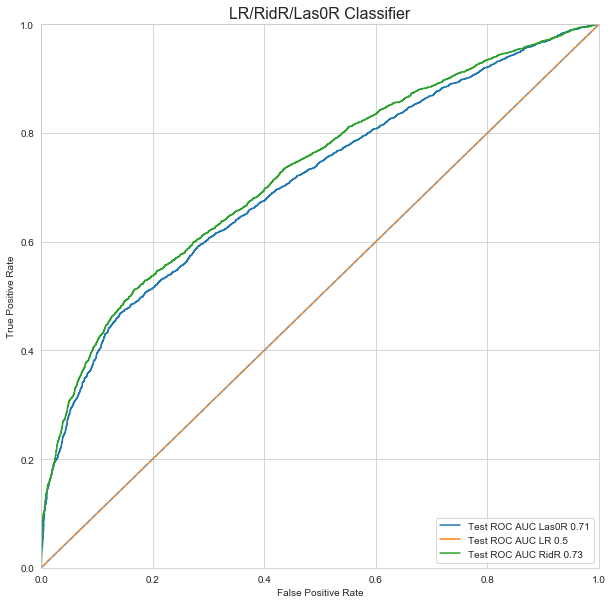

In [530]:
import matplotlib

fpr_test_LR, tpr_test_LR, thresholds_test_LR = roc_curve(y_test, y_test_predict_LR)
fpr_test_RidR, tpr_test_RidR, thresholds_test_RidR = roc_curve(y_test, y_test_predict_RidR)
fpr_test_Las0R, tpr_test_Las0R, thresholds_test_Las0R = roc_curve(y_test, y_test_predict_Las0R)


matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_test_Las0R, tpr_test_Las0R, label='Test ROC AUC {1} {0}'.format(roc_auc_test_Las0R,'Las0R'))
plt.plot(fpr_test_LR, tpr_test_LR, label='Test ROC AUC {1} {0}'.format(roc_auc_test_LR,'LR'))
plt.plot(fpr_test_RidR, tpr_test_RidR, label='Test ROC AUC {1} {0}'.format(roc_auc_test_RidR,'RidR'))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR/RidR/Las0R Classifier', size=16)
plt.legend(loc='lower right')
plt.show()



In [531]:
"""однако при большом штрафе мы видим что Лассо 
выбирает таргет случайно(мы уже видили это ранее-все коэффициенты занулялись)"""
linreg = LinearRegression(normalize=True)
linreg.fit(X_test,Y_test)
y_test_predict_LR = linreg.predict(X_test)
roc_auc_test_LR = np.round(roc_auc_score(y_test, y_test_predict_LR), 2)

alpha=1
ridgereg = Ridge(alpha, normalize=True)
ridgereg.fit(X_test,Y_test)
y_test_predict_RidR = ridgereg.predict(X_test)
roc_auc_test_RidR = np.round(roc_auc_score(y_test, y_test_predict_RidR), 2)


lassoreg = Lasso(alpha, normalize=True)
lassoreg.fit(X_test,Y_test)
y_test_predict_Las0R = lassoreg.predict(X_test)
roc_auc_test_Las0R = np.round(roc_auc_score(y_test, y_test_predict_Las0R), 2)

print("Test_LR: ", roc_auc_test_LR)
print("Test_RidR: ", roc_auc_test_RidR)
print("Test_Las0R: ", roc_auc_test_Las0R)




Test_LR:  0.5
Test_RidR:  0.71
Test_Las0R:  0.5


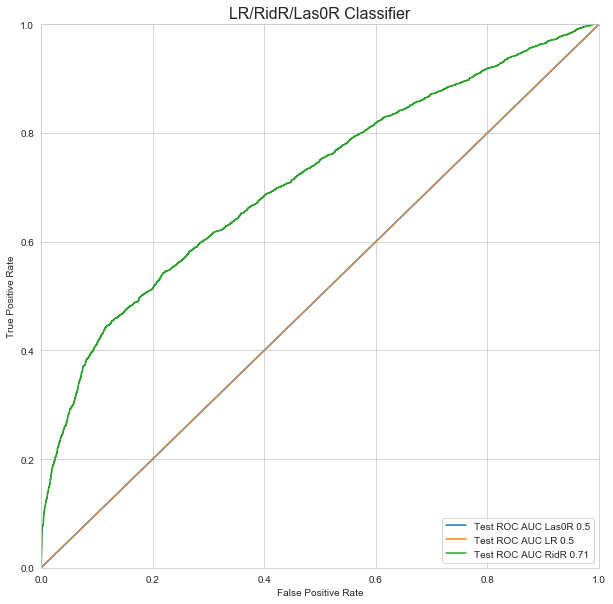

In [532]:
import matplotlib

fpr_test_LR, tpr_test_LR, thresholds_test_LR = roc_curve(y_test, y_test_predict_LR)
fpr_test_RidR, tpr_test_RidR, thresholds_test_RidR = roc_curve(y_test, y_test_predict_RidR)
fpr_test_Las0R, tpr_test_Las0R, thresholds_test_Las0R = roc_curve(y_test, y_test_predict_Las0R)


matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_test_Las0R, tpr_test_Las0R, label='Test ROC AUC {1} {0}'.format(roc_auc_test_Las0R,'Las0R'))
plt.plot(fpr_test_LR, tpr_test_LR, label='Test ROC AUC {1} {0}'.format(roc_auc_test_LR,'LR'))
plt.plot(fpr_test_RidR, tpr_test_RidR, label='Test ROC AUC {1} {0}'.format(roc_auc_test_RidR,'RidR'))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR/RidR/Las0R Classifier', size=16)
plt.legend(loc='lower right')
plt.show()



### 5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

Text(0, 0.5, 'explained_variance_ratio_')

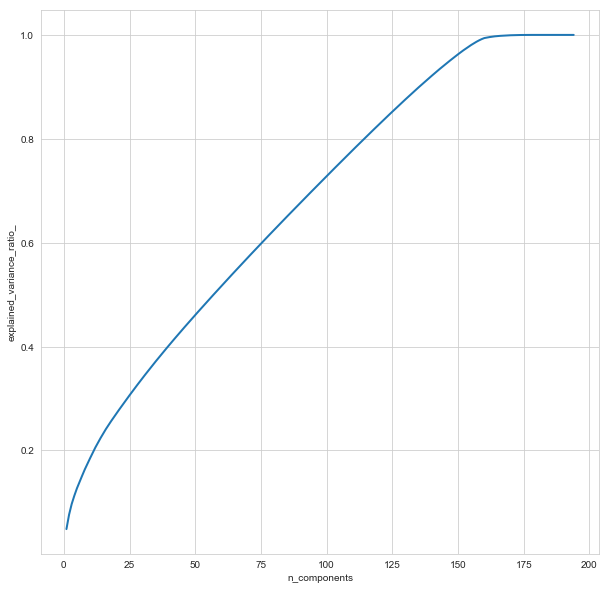

In [546]:
from sklearn.decomposition import PCA, KernelPCA
pca = PCA().fit(X)

cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid(b=1,  axis='both')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')


In [536]:

np.set_printoptions(suppress=True)
pca.explained_variance_ratio_ * 100

array([4.86533871, 2.77299279, 2.05913287, 1.59285469, 1.4300563 ,
       1.24526126, 1.21351065, 1.1893638 , 1.09822113, 1.04838405,
       1.0403551 , 1.01812657, 0.93881547, 0.89555833, 0.87068294,
       0.82927893, 0.78171637, 0.75742359, 0.73423282, 0.72765174,
       0.71534281, 0.7071602 , 0.70129241, 0.69492624, 0.69126375,
       0.68546383, 0.67795654, 0.66533818, 0.66379732, 0.65750588,
       0.65201171, 0.64375082, 0.64173172, 0.6332218 , 0.63054529,
       0.62151915, 0.61552012, 0.61222985, 0.61066773, 0.6070383 ,
       0.59837759, 0.5947872 , 0.5925592 , 0.59010668, 0.58440889,
       0.58103271, 0.57865758, 0.57474545, 0.57363447, 0.57134334,
       0.56804585, 0.56623765, 0.56569799, 0.56327231, 0.55926935,
       0.55872808, 0.55779286, 0.55590563, 0.55503793, 0.55309446,
       0.55126999, 0.5499351 , 0.54791278, 0.54759017, 0.54591566,
       0.54558185, 0.54196597, 0.54175683, 0.54097107, 0.53955561,
       0.53808304, 0.53658426, 0.5356971 , 0.53416561, 0.53319

In [ ]:
# Как видим у нас 1ые 100 компонент объясняют 72% вариативности


In [541]:
pca.explained_variance_ratio_[:100].sum()

0.7280717296959208